# INFO 3350/6350

## Lecture 05: Sentiment scoring

## To do

* Readings
    * *HDA* ch. 4 for today
    * Two articles for Weds
* **Response posts.** See Canvas for schedule and instructions. 
    * **Optional** response for *this week*; due by Tuesday at 4pm.
        * Most people will not write  a response this week
        * Use if you know you'll miss a later one, or are very interested in this week's topic
    * The readings themselves are *always* required. Read every week. Respond only as scheduled.
* HW2 due Thursday night at 11:59pm
* Remember that Ed is the place for questions about any aspect of the course. 
    * Follow up in office hours as needed.
* Classroom for lectures is likely to change. Will announce via Ed if/when it does.

## What are we doing?

We want to determine the *sentiment* of a text and of the individual sentences from which the text is composed.

"Sentiment" can mean a lot of things:

* Positive and negative feelings
* Emotional intensity (could be good or bad)
* Amount or intensity of other emotions (joy, surprise, awe, fear, etc.)
* Maybe even "sentimentalness" (roughly, "nostalgia")

Today, we'll focus on sentiment as the expression of positive and negative feelings at the token level. This is a common case in many text anlaysis problems.

## Supervised and unsupervised

There are two broad ways we could approach the task of senitment analysis:

* **Unsupervised** methods start with **known-informative features** and produce labels or scores from those features.
* **Supervised** methods start with **labeled data** and try to learn the features that best predict the labels.
* Advantages and disadvantages of each
  * In short: unfront labeling costs vs. later validation costs
  
## Warning

Every semester, we see a surprising number of student projects that are built around unsupervised sentiment analysis. These projects tend to be weak, since they rely on a method covered in week 3 that has lots of known limitations and many superior alternatives. Do not fall into this trap.

## Our method

We will work, for now, with **unsupervised** sentiment analysis. But there are lots of supervised approaches, too.

Specifically, we're going to use so-called lexical or dictionary-based methods that assign one or more emotions to a subset of English words. We will assume that each of those words in a given text is an indication that the text contains the corresponding emotion. We can them sum up the emotions over all words in the text to get a measurement of that text's net emotional content.

**Quick exercise:** Do you expect this method to work? What are some potential problems?

## Example case

* From Jockers' [*Syuzhet* vignette](https://cran.r-project.org/web/packages/syuzhet/vignettes/syuzhet-vignette.html). 
 * Note that this is an R package. We can't use it directly.
* "Syuzhet" = "plot" or "subject" in Russian; it refers to narrative order, rather than to the "true" order of the narrative's underlying events (which is called the *fabula*).
* To see the difference, think about a flashback that occurs near the end of a story.

Consider the following story (or "story"):

> I begin this story with a neutral statement.  
  Basically this is a very silly test.  
  You are testing the Syuzhet package using short, inane sentences.  
  I am actually very happy today. 
  I have finally finished writing this package.  
  Tomorrow I will be very sad. 
  I won't have anything left to do. 
  I might get angry and decide to do something horrible.  
  I might destroy the entire package and start from scratch.  
  Then again, I might find it satisfying to have completed my first R package. 
  Honestly this use of the Fourier transformation is really quite elegant.  
  You might even say it's beautiful!

### Score some sentences ...

By show of hands, how many think each sentence is:
* Positive
* Neutral
* Negative

The sentences:
1. **Basically this is a very silly test.**
1. **You are testing the Syuzhet package using short, inane sentences.**  
1. **I have finally finished writing this package.**  
1. **I won't have anything left to do.** 
1. **Honestly this use of the Fourier transformation is really quite elegant.**  

In [1]:
# Enter eyeballed values from in-class survey ...
# Range [-2, 2] strong negative to strong positive
silly    = -0.3
inane    = -0.45
finished = 0.5
left     = -0.75
fourier  = 1.7

# scores for all sentences, includings ones not recorded above
human_scores = [
    0,
    silly,
    inane,
    2,
    finished,
    -2,
    left,
    -2,
    -2,
    1,
    fourier,
    1.5
]

print("Human scores by sentence:", human_scores)
print("Overall human sentiment score:", round(sum(human_scores),3))

Human scores by sentence: [0, -0.3, -0.45, 2, 0.5, -2, -0.75, -2, -2, 1, 1.7, 1.5]
Overall human sentiment score: -0.8


**Confidence check:** Does this strike us as a reasonable summary of the overall positive-negative affect of the sample story? If not, why not?

### Ingest and tokenize the example "story"

Notice that our output data structure is a list of lists. The "outer" list contains sentences. The "inner" lists each contain the tokens in one sentence.

In [2]:
from nltk import sent_tokenize, word_tokenize

# The story. Why triple quotes?
story = '''\
  I begin this story with a neutral statement.  
  Basically this is a very silly test.  
  You are testing the Syuzhet package using short, inane sentences.  
  I am actually very happy today. 
  I have finally finished writing this package.  
  Tomorrow I will be very sad. 
  I won't have anything left to do. 
  I might get angry and decide to do something horrible.  
  I might destroy the entire package and start from scratch.  
  Then again, I might find it satisfying to have completed my first R package. 
  Honestly this use of the Fourier transformation is really quite elegant.  
  You might even say it's beautiful!'''

# Tokenize the story
tokens = [word_tokenize(sent.lower()) for sent in sent_tokenize(story)]
print("Sentences:", len(tokens))
print("Total tokens:", sum([len(sent) for sent in tokens]))
print("\nSample sentences:", tokens[0:2])

Sentences: 12
Total tokens: 118

Sample sentences: [['i', 'begin', 'this', 'story', 'with', 'a', 'neutral', 'statement', '.'], ['basically', 'this', 'is', 'a', 'very', 'silly', 'test', '.']]


Quick aside: **list comprehension**:

* It's a compact way to write a for loop and store the result in a list.
* Good for quick stuff, but not flexible and not very legible.

```
tokens = [word_tokenize(sent.lower()) for sent in sent_tokenize(story)]
```

is the same as

```
tokens = []
for sent in sent_tokenize(story):
    tokens.append(word_tokenize(sent.lower()))
```

### Set up sentiment dictionaries

We want to compare a couple of them. Specifically, we'll use:

* NLTK's copy of Hu and Liu's lexicon ([paper](https://www.cs.uic.edu/~liub/publications/kdd04-revSummary.pdf) | [dataset](https://www.cs.uic.edu/~liub/FBS/sentiment-analysis.html))
* Mohammad's [EmoLex](http://saifmohammad.com/WebPages/NRC-Emotion-Lexicon.htm) from the Canadian National Research Council (NRC). 
    * Crowd-sourced word associations.
    * Some are ... questionable? See HW3.

Are these good and suitable choices for our task? Let's (begin to) find out!

In [3]:
from   collections import defaultdict
import nltk
import os
import random

nltk.download('opinion_lexicon') # Need to download this the first time used

# NLTK simple lexicon (from Hu and Liu (2004))
nltk_lexicon = {
    'positive' : set(nltk.corpus.opinion_lexicon.positive()), # Why cast to a set?
    'negative' : set(nltk.corpus.opinion_lexicon.negative())
}

# Print a sample of the NLTK lexicon
print('NLTK lexicon sample')
for key in nltk_lexicon.keys():
    print(f'{key}:', random.sample(tuple(nltk_lexicon[key]), 5))
    
# NRC EmoLex lexicon (from Mohammad, http://sentiment.nrc.ca/lexicons-for-research/)
# No package for this, just read the data from a local file
emolex_file = os.path.join('..', 'data', 'lexicons', 'emolex.txt')
nrc_lexicon = defaultdict(dict) # Like Counter(), defaultdict eases dictionary creation
with open(emolex_file, 'r') as f:
    # emolex file format is: word emotion value
    for line in f:
        word, emotion, value = line.strip().split()
        nrc_lexicon[word][emotion] = int(value)
        
# Print a sample of the NRC EmoLex lexicon
print('\nNRC lexicon sample')       
for key in random.sample(tuple(nrc_lexicon.keys()), 2):
    print(f'{key}:', nrc_lexicon[key])

[nltk_data] Downloading package opinion_lexicon to
[nltk_data]     /Users/mwilkens/nltk_data...
[nltk_data]   Package opinion_lexicon is already up-to-date!


NLTK lexicon sample
positive: ['refunded', 'homage', 'courtly', 'ebullient', 'relief']
negative: ['condescension', 'bruises', 'steals', 'vibration', 'crashed']

NRC lexicon sample
suspicion: {'anger': 0, 'anticipation': 0, 'disgust': 0, 'fear': 1, 'joy': 0, 'negative': 1, 'positive': 0, 'sadness': 0, 'surprise': 0, 'trust': 0}
remnant: {'anger': 0, 'anticipation': 0, 'disgust': 0, 'fear': 0, 'joy': 0, 'negative': 0, 'positive': 0, 'sadness': 0, 'surprise': 0, 'trust': 0}


### Define scoring function

Set up a function to score a word as positive or negative using either the NLTK or NRC dictionary.

In [4]:
def word_sentiment_score(word, method='nrc', lex=nrc_lexicon):
    '''
    Takes a word, optional method in ['nrc', 'nltk'], and optional lexicon dictionary.
    Returns 1 (if positive), -1 (if negative), 0 (neutral), or None (not in lex).
    '''
    word = word.lower() # Handle non-case-folded inputs
    if method.lower() == 'nrc':
        if word in lex: # Only score words that are in the lexicon
            pos = lex[word]['positive']
            neg = lex[word]['negative']
            if pos == neg: # Ties (mostly 0==0) return zero
                return 0
            elif pos > neg:
                return 1
            else:
                return -1
    elif method.lower() == 'nltk':
        if word in lex['positive']:
            return 1
        elif word in lex['negative']:
            return -1
    else:
        raise NameError("Method not in ['nrc', 'nltk']")
    return None # If word not in lexicon, return None (not zero). Why do this?

In [5]:
print("NRC  'analyst':", word_sentiment_score('analyst'))
print("NLTK 'analyst':", word_sentiment_score('analyst', method='nltk', lex=nltk_lexicon))

NRC  'analyst': 1
NLTK 'analyst': None


### Score our example sentences

For reference, here are our class-crowd-sourced scores:

In [6]:
# Human scores
print("Method: human")
print("Sentence scores:", human_scores)
print("Summary score:", sum(human_scores))

Method: human
Sentence scores: [0, -0.3, -0.45, 2, 0.5, -2, -0.75, -2, -2, 1, 1.7, 1.5]
Summary score: -0.7999999999999998


In [7]:
# Calculate and compare dictionary scores

# Scoring methods for input
methods = {
    'nltk':nltk_lexicon,
    'nrc' :nrc_lexicon
}

# Calculate, record, and print scores
method_scores = {} # To store results
for method in methods:
    sentence_scores = [] # Could rewrite next few lines as a list comprehension
    for sent in tokens:
        sentence_score = 0
        for word in sent:
            word_score = word_sentiment_score(word, method=method, lex=methods[method])
            if word_score != None:
                sentence_score += word_score
        sentence_scores.append(sentence_score)
    method_scores[method] = sentence_scores # Save sentence-level scores
    # Print results
    print("Method:", method)
    print("Sentence scores:", sentence_scores)
    print("Summary score:", sum(sentence_scores),'\n')

Method: nltk
Sentence scores: [0, -1, -1, 1, 0, -1, 0, -2, -2, 1, 1, 1]
Summary score: -3 

Method: nrc
Sentence scores: [1, -1, -1, 1, 1, 0, 0, -2, 0, 0, 1, 1]
Summary score: 1 



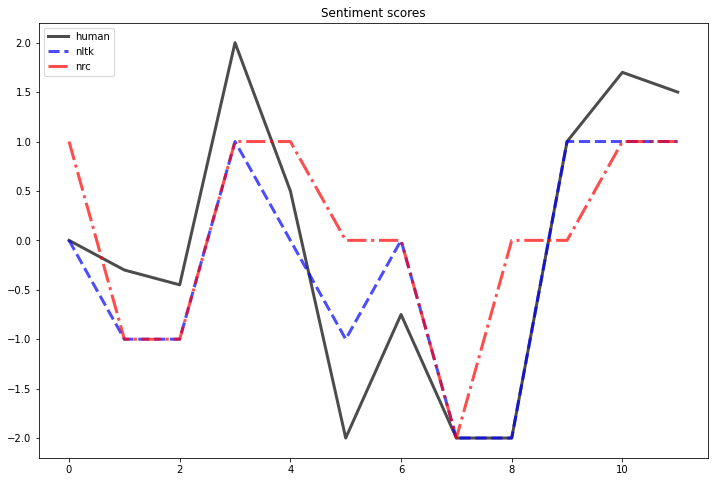

  I begin this story with a neutral statement.  
  Basically this is a very silly test.  
  You are testing the Syuzhet package using short, inane sentences.  
  I am actually very happy today. 
  I have finally finished writing this package.  
  Tomorrow I will be very sad. 
  I won't have anything left to do. 
  I might get angry and decide to do something horrible.  
  I might destroy the entire package and start from scratch.  
  Then again, I might find it satisfying to have completed my first R package. 
  Honestly this use of the Fourier transformation is really quite elegant.  
  You might even say it's beautiful!


In [8]:
# Visualize and print the story for discussion
import matplotlib.pyplot as plt

x = list(range(len(tokens)))
fig, ax = plt.subplots(figsize=(12,8))
plt.plot(x, human_scores, '-',  c='black', label='human', alpha=0.7, linewidth=3)
plt.plot(x, method_scores['nltk'], '--', c='blue', label='nltk', alpha=0.7, linewidth=3)
plt.plot(x, method_scores['nrc'], '-.', c='red', label='nrc', alpha=0.7, linewidth=3)
plt.legend()
plt.title("Sentiment scores")
plt.show()

print(story)

### Discuss 

Do these scores make sense? 

* We can look at specific instances, like NRC on the first sentence (next code block)
* **Is this a happy story or not?**
 * Do the summary scores reflect our judgment about that?
 * If not, why not and how could we improve those scores?

In [9]:
# Token-level NRC scores for example sentence 1
for word in tokens[0]:
    print(f'{word.ljust(11)}{word_sentiment_score(word)}')

i          None
begin      0
this       None
story      0
with       None
a          None
neutral    0
statement  1
.          None


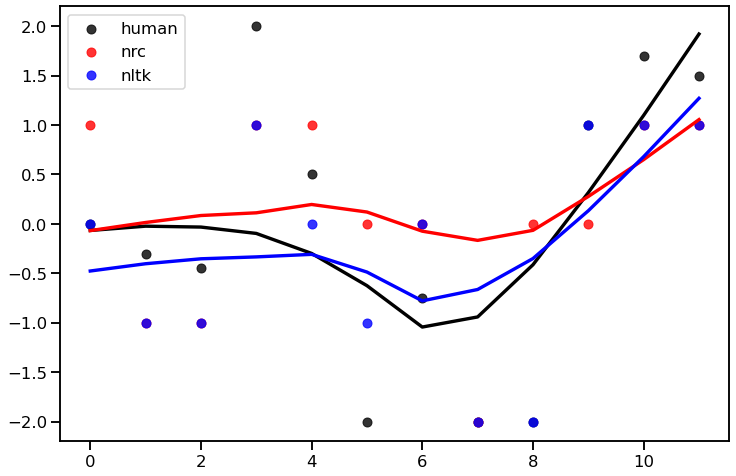

In [10]:
# Use Seaborn to plot data with lowess (local regression) fit
import seaborn as sns

sns.set_context('talk')
fig, ax = plt.subplots(figsize=(12,8))
sns.regplot(x=x, y=human_scores, lowess=True, color='k', label='human')
sns.regplot(x=x, y=method_scores['nrc'], lowess=True, color='r', label='nrc')
sns.regplot(x=x, y=method_scores['nltk'], lowess=True, color='b', label='nltk')
plt.legend()
plt.show()

## *Madame Bovary* (Flaubert, 1856/1857)

Expected arc: starts happy, ends sad.

Note that we do not lowercase our text (why not?), nor do we remove stopwords and punctuation (again, why not?). We *could* do both of those things, but would want to be sure that there weren't any name collisions in our text (that is, names that have affective associations when used as common words). We might also want to preserve case and punctuation for other tasks in our processing pipeline, even if we don't need them for our sentiment score.

In [11]:
# Read and tokenize the novel
bovary_file = os.path.join('..', 'data', 'texts', 'F-Flaubert-Madame_Bovary-1857-M.txt')
with open(bovary_file, 'r') as f:
    bovary_text = f.read()
bovary = [word_tokenize(sent) for sent in sent_tokenize(bovary_text)]
print("Sentences:", len(bovary))
print("Total tokens:", sum([len(sent) for sent in bovary]))

Sentences: 5695
Total tokens: 140026


Note one small change below: we divide sentence sentiment by sentence length, so that long sentences don't count more than short ones.

In [12]:
# Score it using NLTK and NRC methods
bovary_scores = {}
for method in methods:
    sentence_scores = []
    for sent in bovary:
        sentence_score = 0
        for word in sent:
            word_score = word_sentiment_score(word, method=method, lex=methods[method])
            if word_score != None:
                sentence_score += word_score
        sentence_scores.append(sentence_score/len(sent))
    bovary_scores[method] = sentence_scores
    print("Method:", method)
    print("Summary score:", round(sum(bovary_scores[method]),2),'\n')

Method: nltk
Summary score: -18.04 

Method: nrc
Summary score: 50.89 



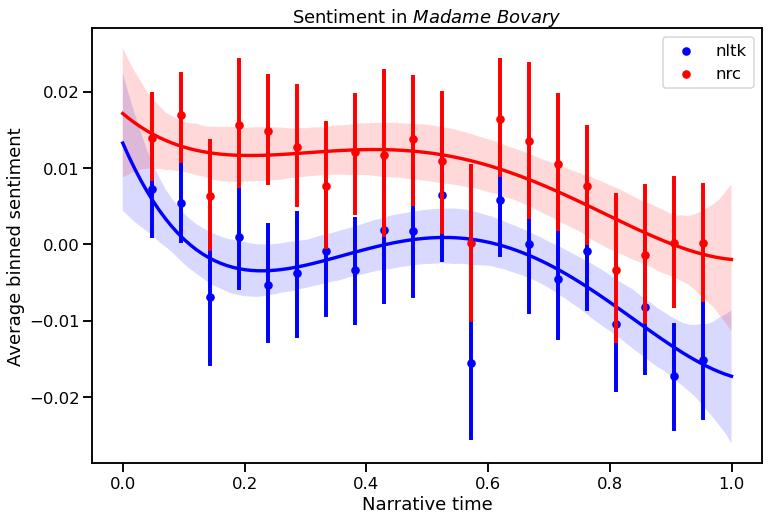

In [17]:
# Plot results with 4th-order polynomial fit (why?)
fig, ax = plt.subplots(figsize=(12,8))
x_bov = [i/len(bovary) for i in range(len(bovary))] # normalize length as fraction of all sentences
sns.regplot(x=x_bov, y=bovary_scores['nltk'], order=4, scatter=False, color='b', label=None)
sns.regplot(x=x_bov, y=bovary_scores['nltk'], x_bins=20, scatter=True, fit_reg=False, color='b', label='nltk')
sns.regplot(x=x_bov, y=bovary_scores['nrc'], order=4, scatter=False, color='r', label=None)
sns.regplot(x=x_bov, y=bovary_scores['nrc'], x_bins=20, scatter=True, fit_reg=False, color='r', label='nrc')
plt.title("Sentiment in $\it{Madame\ Bovary}$")
plt.xlabel("Narrative time")
plt.ylabel("Average binned sentiment")
plt.legend()
plt.show()

**Discuss:** How would you compare and evaluate the results of these two methods on this text?

## Where to go from here

* More validation!
  * Is your lexicon good? For this kind of text? Written at this time?
* Other dictionaries
  * Develop your own?
  * See Jurafsky and Martin for clever and/or complex ideas
    * Example: tag adjectives. Those that appear on either side of the token `and` probably have the same sentiment polarity; those linked by `but` are likely opposites.
    * Lots of embedding-based approaches, too.
* Other aspects of sentiment/emotion/affect 
  * NRC 'anger', 'surprise', 'trust', etc.
* Other texts and other *types* of text
* **Combine sentiment with other kinds of text- and sentence-level scoring**
  * Gender, time period (linguistic drift, yikes!), translations of the same text, news coverage of candidates, ...
  * Problem set 3 will try this
* More ideas?